# Electrode Expansion
Plot expansion for UM battery lab pouch cell parameters

In [67]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# Expansion Functions and other Battery Parameters

In [68]:
# x100 = 0.822873
# y100 = 0.033498
eps_n_data = 0.6234
eps_p_data = 0.4542

In [69]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0,
            # Setting Electrode volume fractions
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            # Initializing Particle Concentration
            # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
            # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

# Define Experiment and Model

In [70]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
c_rate_c = 'C/20'
c_rate_d = 'C/20'
dis_set = " until 3V"
experiment = pybamm.Experiment(
    [
        # "Discharge at "+c_rate_d+dis_set,
        # "Rest for 5 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)
spm = pybamm.lithium_ion.SPM(
    {
        "particle mechanics": "swelling only",
    }
)

# Run Simulation

In [71]:
sol = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol = sol.solve(initial_soc=0)

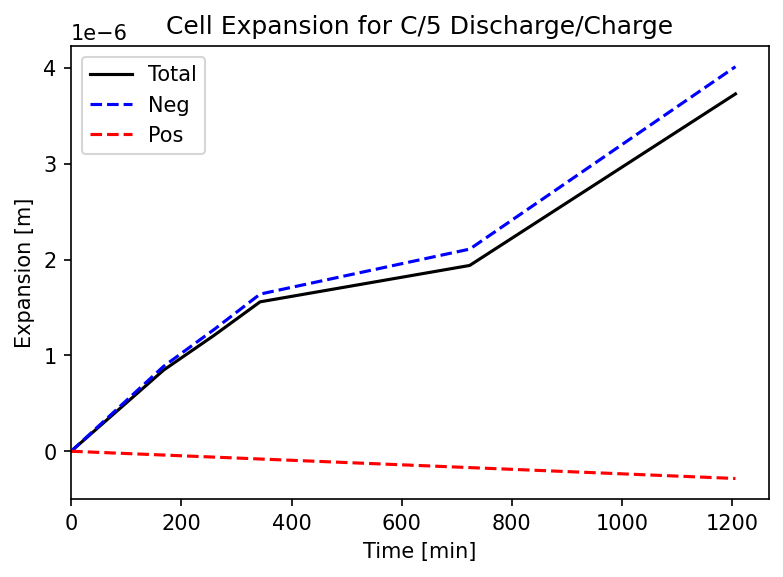

In [72]:
t = sol["Time [min]"].entries
cell_thickness = sol["Cell thickness change [m]"].entries
cell_thickness_n = sol["Negative Electrode thickness change [m]"].entries
cell_thickness_p = sol["Positive Electrode thickness change [m]"].entries
plt.figure()
plt.plot(t,cell_thickness,'k')
plt.plot(t,cell_thickness_n,'b--')
plt.plot(t,cell_thickness_p,'r--')
plt.legend(['Total' , 'Neg'  , 'Pos'])
plt.xlim(left=0)
plt.xlabel('Time [min]')
plt.ylabel('Expansion [m]')
plt.title('Cell Expansion for C/5 Discharge/Charge');
plt.savefig('exp plot.png')

Text(0.5, 1.0, 'Avg Conc vs Time')

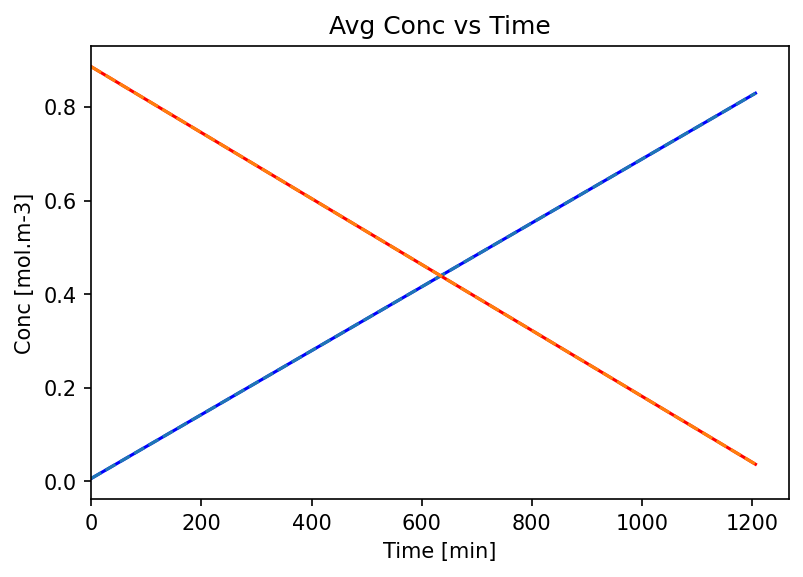

In [73]:
cs_avg_n = sol["Average negative particle concentration"].entries
cs_avgr_n = sol["R-averaged negative particle concentration"].entries
cs_avg_p = sol["Average positive particle concentration"].entries
cs_avgr_p = sol["R-averaged positive particle concentration"].entries
plt.figure()
plt.plot(t,cs_avg_n,'b')
plt.plot(t,cs_avgr_n[0,:],'--')
plt.plot(t,cs_avg_p,'r')
plt.plot(t,cs_avgr_p[0,:],'--')
plt.xlim(left=0)
plt.xlabel('Time [min]')
plt.ylabel('Conc [mol.m-3]')
plt.title('Avg Conc vs Time')

In [74]:
# quick_plot =pybamm.QuickPlot(sol, figsize=(14,7),output_variables=
# ['Negative particle surface concentration [mol.m-3]','R-averaged negative particle concentration [mol.m-3]'])
# quick_plot.dynamic_plot();

In [75]:
# spm.variable_names()
# spm.variables.search("concentration")
# parameter_values.search("parallel")

# Plot Expansion Function

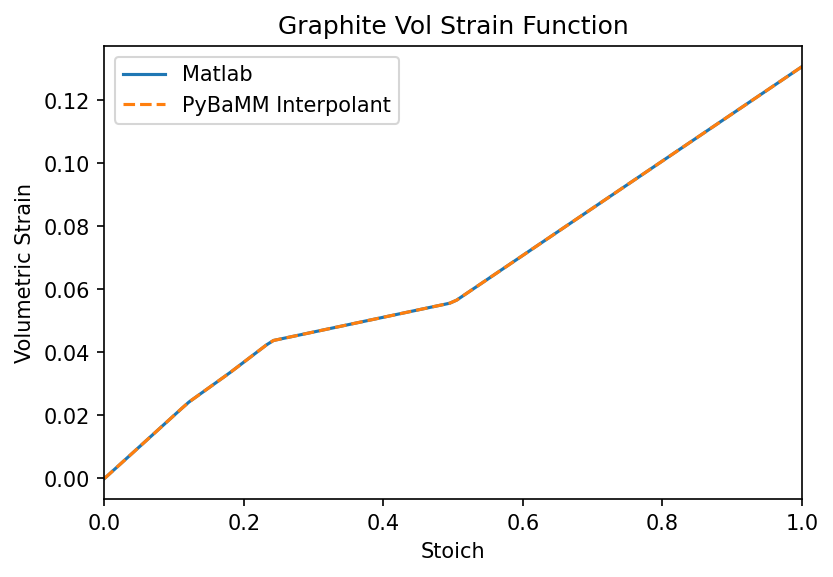

In [89]:
def graphite_volume_change(sto):
    a = 0.50
    b = 0.24
    c = 0.18 
    d = 0.12
    t_change = (
        (0 <= sto and sto < d)*(2.4060/d*sto)+
        (d <= sto and sto < c)*(-(2.4060-3.3568)/(c-d)*(sto-d)+2.4060)+
        (c <= sto and sto < b)*(-(3.3568-4.3668)/(b-c)*(sto-c)+3.3568)+
        (b <= sto and sto < a)*(-(4.3668-5.5830)/(a-b)*(sto-b)+4.3668)+
        (a <= sto and sto <= 1)*(-(5.583-13.0635)/(1-a)*(sto-a)+5.583)
    )
    t_change = t_change/100
    return t_change
sto = np.linspace(0,1,100)
yout = np.zeros(len(sto))
yout1 = np.zeros(len(sto))
for i in range(len(sto)):
    yout[i] = graphite_volume_change(sto[i])
    yout1[i] = graphite_volume_change_mohtat(sto[i]).evaluate()
plt.figure()
plt.plot(sto,yout)
plt.plot(sto,yout1,'--')
plt.xlim([0,1])
plt.legend(['Matlab','PyBaMM Interpolant'])
plt.xlabel('Stoich')
plt.ylabel('Volumetric Strain')
plt.title('Graphite Vol Strain Function')
plt.savefig('exp_func')

# Import Data

In [88]:
DIR = "./data/"
cell = 1
cell_no = f'{cell:02d}'
data1=pd.read_csv(DIR+"ocv_data_cell_"+cell_no+".csv")
N =data1.N.unique()
data = data1[data1['N']==N[0]]
data.head()

,N,t,Q,V,E,T
0,0,0.000000,0.000000,2.896056,0.1,20.606882
1,0,10.000000,0.000695,2.920593,0.1,20.591040
2,0,20.000001,0.001390,2.936663,0.1,20.694017
3,0,30.000001,0.002085,2.948637,0.1,20.804914
4,0,40.000002,0.002780,2.958483,0.2,20.987106


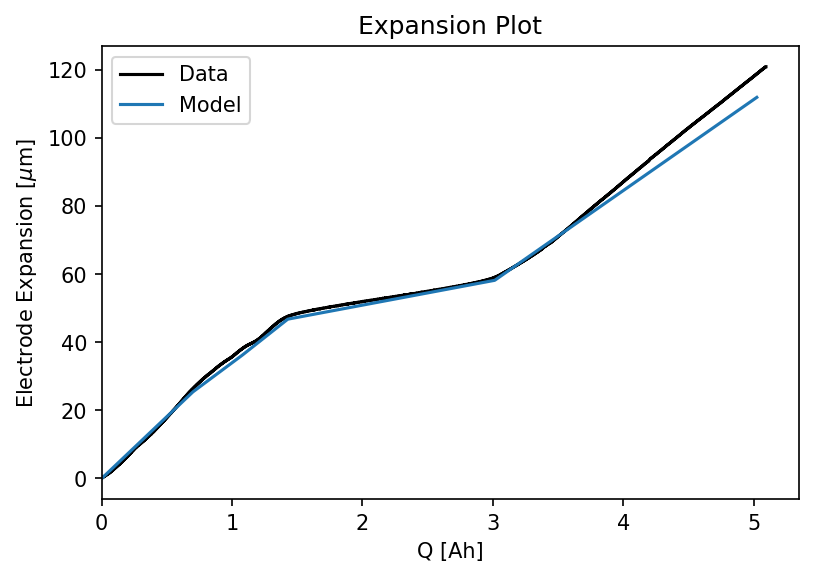

In [83]:
Q = -sol['Discharge capacity [A.h]'].entries
plt.figure(dpi=150)
plt.plot(data['Q'],data['E'],'k')
plt.plot(Q,cell_thickness*30e6)
plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Electrode Expansion [$\mu$m]')
plt.title('Expansion Plot')
plt.legend(['Data' , 'Model'])
plt.savefig('exp data')

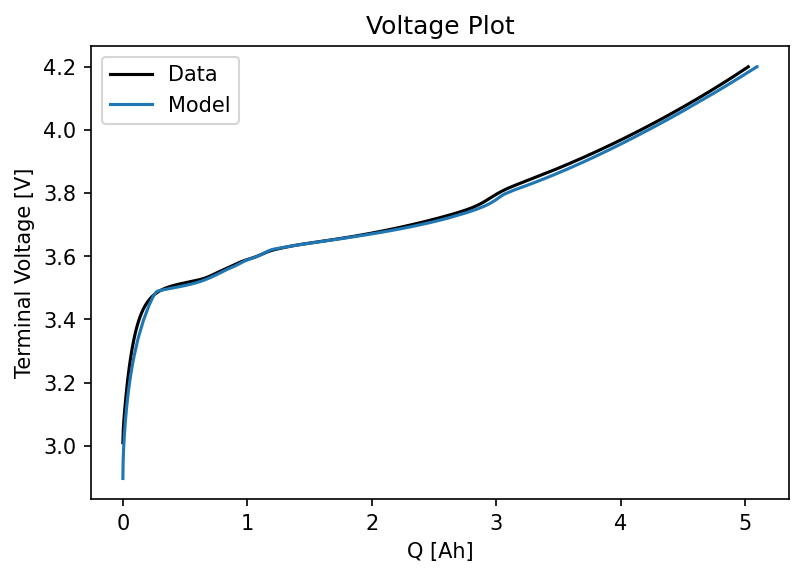

In [82]:
Vt = sol["Terminal voltage [V]"].entries
plt.figure()
plt.plot(Q,Vt,'k')
plt.plot(data['Q'],data['V'])
# plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Terminal Voltage [V]')
plt.title('Voltage Plot')
plt.legend(['Data' , 'Model'])
plt.savefig('vol data')

In [80]:
spm.variables.search("A.h")


Discharge capacity [A.h]
Loss of capacity to SEI [A.h]
Loss of capacity to lithium plating [A.h]
Negative electrode capacity [A.h]
Positive electrode capacity [A.h]
Total capacity lost to side reactions [A.h]
